In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from  tensorflow import keras 
sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)

augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [5]:

inputs = keras.Input(shape=(227,227,3))
targets = keras.Input(shape=(10,))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# ### first branch


# branch_exit = Branch(tf.compat.v1.get_default_graph().unique_name("branch_e"))(x,targets)
x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("main_path124"))(x)
x = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("main_path64"))(x)
x = keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("exit"))(x)


# model = keras.Model(inputs=(inputs), outputs=[x,branch_exit], name="alexnet")
model = brevis.BranchModel(inputs=(inputs), outputs=[x], name="alexnet")

model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# student_model.save("models/alexNetv6_second_Exit.hdf5")
model.summary()


# model.fit(train_ds, validation_ds, 1)


preset: Other
Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27,

C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [3]:
loss_fn = brevis.utils.evidence_crossentropy()
brevisModel = (brevis.BranchModel(name="../models/alexNetv6_logits.hdf5", custom_objects={})
            .add_branches(branches.branch.newBranch_flatten_evidence,
                          ["max_pooling2d",
                            "max_pooling2d_1",
                            "dense"],
                          target_input=True,loop=False)
            )
brevisModel.compile(loss=loss_fn, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
brevisModel.summary()

targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  max_pooling2d
add Branch to branch point  max_pooling2d_1
add Branch to branch point  dense
branch added <brevis.core_v2.BranchModel object at 0x0000018213352BC8>
branch_softmax :  True
branch_softmax_1 :  True
branch_softmax_2 :  True

preset: Other
Model: "alexnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 55, 55, 96)   34944       ['input_2[0][0]']                
 

In [6]:
brevisModel.fit(train_ds,validation_ds,1)

Freezing Main Layers and setting branch layers training to true
1406/1406 [==============================] - ETA: 0s - loss: 7.6283 - dense_2_loss: 2.2712 - branch_softmax_3_loss: 1.4688 - branch_softmax_4_loss: 1.2005 - branch_softmax_5_loss: 0.4167 - dense_2_1_loss: 2.2711 - dense_2_accuracy: 0.9147 - branch_softmax_3_accuracy: 0.4910 - branch_softmax_4_accuracy: 0.5878 - branch_softmax_5_accuracy: 0.8711 - dense_2_1_accuracy: 0.9148 - branch_softmax_3_evidence: 0.0187 - branch_softmax_3_mean_ev_succ: 0.1993 - branch_softmax_3_mean_ev_fail: 0.1763 - branch_softmax_4_evidence: 0.0206 - branch_softmax_4_mean_ev_succ: 0.2430 - branch_softmax_4_mean_ev_fail: 0.1582 - branch_softmax_5_evidence: 0.1452 - branch_softmax_5_mean_ev_succ: 1.5817 - branch_softmax_5_mean_ev_fail: 0.4048
Epoch 1: saving model to models\alexnet_branched.hdf5.hdf5
1406/1406 [==============================] - 278s 195ms/step - loss: 7.6283 - dense_2_loss: 2.2712 - branch_softmax_3_loss: 1.4688 - branch_softmax_4_los

In [4]:

brevisModel.fit(train_ds,validation_ds,1)

Freezing Main Layers and setting branch layers training to true
1406/1406 [==============================] - ETA: 0s - loss: 5.3521 - dense_2_loss: 2.2724 - branch_softmax_loss: 1.4721 - branch_softmax_1_loss: 1.1961 - branch_softmax_2_loss: 0.4114 - dense_2_accuracy: 0.9139 - branch_softmax_accuracy: 0.4911 - branch_softmax_1_accuracy: 0.5876 - branch_softmax_2_accuracy: 0.8696 - branch_softmax_evidence: 0.0235 - branch_softmax_mean_ev_succ: 0.2495 - branch_softmax_mean_ev_fail: 0.2198 - branch_softmax_1_evidence: 0.0202 - branch_softmax_1_mean_ev_succ: 0.2400 - branch_softmax_1_mean_ev_fail: 0.1494 - branch_softmax_2_evidence: 0.1329 - branch_softmax_2_mean_ev_succ: 1.4388 - branch_softmax_2_mean_ev_fail: 0.3764
Epoch 1: saving model to models\alexnet_branched.hdf5.hdf5
1406/1406 [==============================] - 209s 144ms/step - loss: 5.3521 - dense_2_loss: 2.2724 - branch_softmax_loss: 1.4721 - branch_softmax_1_loss: 1.1961 - branch_softmax_2_loss: 0.4114 - dense_2_accuracy: 0.91

In [5]:
model.evaluate(test_ds)

input_1
conv2d
conv2d
batch_normalization
batch_normalization
max_pooling2d
max_pooling2d
conv2d_1
conv2d_1
batch_normalization_1
batch_normalization_1
max_pooling2d_1
max_pooling2d_1
conv2d_2
conv2d_2
batch_normalization_2
batch_normalization_2
conv2d_3
conv2d_3
batch_normalization_3
batch_normalization_3
conv2d_4
conv2d_4
batch_normalization_4
batch_normalization_4
max_pooling2d_2
max_pooling2d_2
flatten
flatten
dense
dense
branch_flatten
branch124
dropout
branch64
main_path124
branch_output
main_path64
branch_softmax
exit
targets
  1/312 [..............................] - ETA: 6:27 - loss: 14.0744 - exit_loss: 4.9234 - branch_softmax_loss: 9.1511 - exit_accuracy: 0.1250 - branch_softmax_accuracy: 0.0625input_1
conv2d
conv2d
batch_normalization
batch_normalization
max_pooling2d
max_pooling2d
conv2d_1
conv2d_1
batch_normalization_1
batch_normalization_1
max_pooling2d_1
max_pooling2d_1
conv2d_2
conv2d_2
batch_normalization_2
batch_normalization_2
conv2d_3
conv2d_3
batch_normalization_3

[12.841876029968262,
 5.4054155349731445,
 7.43646240234375,
 0.08092948794364929,
 0.09965945780277252]

In [18]:

identifier= ['dense_13']
layers = [l for l in model.layers]
# print(layers)

inputs =[]
# x =  model.inputs[0]

outputs = []

ready = False
target_input = True
for i in model.inputs:
    if i.name == "targets":
        ready = True
        # print
    inputs.append(i)
if target_input:
    print("targets already present? ",ready)

    if not ready:
        print("added targets")
        targets = keras.Input(shape=(10,), name="targets")
        inputs.append(targets) #shape is (1,) for sparse_categorical_crossentropy
    else:
        targets = model.get_layer('targets').output

x = layers[0].output
for i in range(1,len(layers)):
    # if i == layer_id:
        # x = new_layer(x)
    # else:
        # print("input: ", layers[i].input)
        # print("inputX ", type(x))
        # if type(x) is not list :
            # print("yes")
        # inputs = layers[i].input
        if "dense" in layers[i].name:
            x = layers[i](x)
            new_branch = branches.branch.newBranch_flatten(x,targets = targets)
            outputs.append(new_branch)
            x = branches.branch.branch_finished(0,name=tf.compat.v1.get_default_graph().unique_name("branch_finished"))(x,new_branch)
        else:        
            x = layers[i](x)
        #find branch point
#         if layers[i].name in identifier:
#             print("add Branch to branch point ",layer.name)
#             new_branch = brevis.branches.branch.newBranch_flatten(layer.output,targets = targets)
#             x = branch.branch_finished(0,name=tf.compat.v1.get_default_graph().unique_name("branch_finished"))(x,new_branch)
outputs.append(x)
new_model = brevis.BranchModel(inputs=[inputs], outputs=[outputs])
new_model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
new_model.summary()# train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=False)

targets already present?  False
added targets

preset: Other
Model: "branch_model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 55, 55, 96)   34944       ['input_19[0][0]']               
                                                                                                  
 batch_normalization_45 (BatchN  (None, 55, 55, 96)  384         ['conv2d_45[1][0]']              
 ormalization)                                                                                    
                        

In [19]:
# model.fit(train_ds, validation_ds, 1)
new_model.evaluate(test_ds)

312/312 [==============================] - 7s 23ms/step - loss: 4.5976 - branch_softmax_9_loss: 3.0916 - exit_9_loss: 1.5059 - branch_softmax_9_accuracy: 0.0917 - exit_9_accuracy: 0.4722


[4.597559452056885,
 3.0916459560394287,
 1.505914330482483,
 0.09174679219722748,
 0.47215545177459717]

In [20]:
new_model.fit(train_ds, validation_ds, 1)

Freezing Main Layers and setting branch layers training to true
1406/1406 [==============================] - ETA: 0s - loss: 2.8050 - branch_softmax_9_loss: 1.2571 - exit_9_loss: 1.5479 - branch_softmax_9_accuracy: 0.5469 - exit_9_accuracy: 0.4564
Epoch 1: saving model to models\branch_model_9_branched.hdf5.hdf5
1406/1406 [==============================] - 84s 57ms/step - loss: 2.8050 - branch_softmax_9_loss: 1.2571 - exit_9_loss: 1.5479 - branch_softmax_9_accuracy: 0.5469 - exit_9_accuracy: 0.4564 - val_loss: 2.6666 - val_branch_softmax_9_loss: 1.1525 - val_exit_9_loss: 1.5141 - val_branch_softmax_9_accuracy: 0.5915 - val_exit_9_accuracy: 0.4784


In [ ]:


# x = model.inputs
# for i, layer in enumerate(model.layers):
#     print(i)
#     if i <1:
#         continue
# # for i in range(len(new_model.layers)):
#     print("layer", layer, "x",x)
#     x = layer(x)
#     if exact == True:
#         if layer.name in identifier:

#             print("add Branch to branch point ",layer.name)
#             new_branch = customBranch[min(branches, len(customBranch)-1)](layer.output,targets = targets)
#             x = branch.branch_finished(0,name=tf.compat.v1.get_default_graph().unique_name("branch_finished"))(x,new_branch)
#             # try:
#                 # new_model.layers[i+1].inputs.append(branch_flag)
#             # except:
#                 # print("no layer after branch point")
#             outputs.append(new_branch)
                            

In [35]:
def add(model, identifier =[""], customBranch = [],exact = True, target_input= True, compact = False):
        """ add branches to the provided model, aka modifying an existing model to include branches.
            identifier: takes a list of names of layers to branch on is blank, branches will be added to all layers except the input and final layer. Can be a list of layer numbers, following the numbering format of model.layers[]
            If identifier is not blank, a branch will be added to each layer with identifier in its name. (identifier = "dense", all dense layers will be branched.)
            Warning! individual layers are defined according to how TF defines them. this means that for layers that would be normally grouped, they will be treated as individual layers (conv2d, pooling, flatten, etc)
            customBranch: optional function that can be passed to provide a custom branch to be inserted. Check "newBranch" function for default shape of branches and how to build custom branching function. Can be provided as a list and each branch will iterate through provided customBranches, repeating last the last branch until function completes
        """
        # model = keras.Model([model.input], [model_old.output], name="{}_branched".format(model_old.name))
        # model.summary()

        # outputs = [model.outputs]
        # outputs.append(newBranch(model.layers[6].output))
        # new_model = keras.Model([model.input], outputs, name="{}_branched".format(model.name))
        # new_model.summary()
        outputs = []
        for i in model.outputs:
            outputs.append(i)
        
        inputs = []
        ready = False
        
        targets= None
        
        for i in model.inputs:
            if i.name == "targets":
                ready = True
            inputs.append(i)
        if target_input:
            print("targets already present? ",ready)

            if not ready:
                print("added targets")
                targets = keras.Input(shape=(10,), name="targets")
                inputs.append(targets) #shape is (1,) for sparse_categorical_crossentropy
            else:
                targets = model.get_layer('targets').output

        #add targets as an input to the model so it can be used for the custom losses.
        #   input size is the size of the     
        #add target input 
        new_model = brevis.BranchModel(inputs=inputs, outputs=outputs,name = model.name, transfer=model.transfer, custom_objects=model.custom_objects)

        # outputs = []


        old_output = outputs
        # outputs.append(i in model.outputs) #get model outputs that already exist 

        if type(identifier) != list:
            identifier = [identifier]

        if type(customBranch) != list:
            customBranch = [customBranch]
        if len(customBranch) == 0:
            customBranch = [branch.newBranch_flatten]
        branches = 0
        # print(customBranch)
        if len(identifier) > 0:
            # print("Matching Branchpoint by id number")
            if type(identifier[0]) == int:
                for i in identifier: 
                    try:
                        outputs.append(customBranch[min(branches, len(customBranch))-1](new_model.layers[i].output,targets = targets))
                        branches=branches+1
                    except:
                        pass
            else:
                print("Matching Branchpoint by name, exact: ",exact)
                x = new_model.outputs
                # x = layer(x[0])
                x = new_model.layers[0].output
                # print("input", x)
                for i, layer in enumerate(new_model.layers):
                    print(i)
                    
                    if i <1:
                        continue
                # for i in range(len(new_model.layers)):
                    print("layer", layer, "x",x)
                    x = layer(x)
                    if exact == True:
                        
                        if layer.name in identifier:
                            
                            print("add Branch to branch point ",layer.name)
                            new_branch = customBranch[min(branches, len(customBranch)-1)](layer.output,targets = targets)
                            x = branch.branch_finished(0,name=tf.compat.v1.get_default_graph().unique_name("branch_finished"))(x,new_branch)
                            # try:
                                # new_model.layers[i+1].inputs.append(branch_flag)
                            # except:
                                # print("no layer after branch point")
                            outputs.append(new_branch)
                            
                            branches=branches+1
                    else:
                        if any(id in new_model.layers[i].name for id in identifier):
                            print("add Branch to branch point ",new_model.layers[i].name)
                            outputs.append(customBranch[min(branches, len(customBranch)-1)](new_model.layers[i].output,targets = targets))
                            branches=branches+1
        else: #if identifier is blank or empty
            # print("nothing")
            for i in range(1-len(new_model.layers)-1):
                # print(new_model.layers[i].name)
                # if "dense" in new_model.layers[i].name:
                # outputs = newBranch(new_model.layers[i].output,outputs)
                outputs = customBranch[min(branches, len(customBranch))-1](new_model.layers[i].output,outputs,targets = targets)
                branches=branches+1
            # for j in range(len(new_model.layers[i].inbound_nodes)):
            #     print(dir(new_model.layers[i].inbound_nodes[j]))
            #     print("inboundNode: " + new_model.layers[i].inbound_nodes[j].name)
            #     print("outboundNode: " + new_model.layers[i].outbound_nodes[j].name)
        # print(outputs)
        # print(new_model.input)
        # outputs.pop(0)
        # print(outputs)
        # input_layer = layers.Input(batch_shape=new_model.layers[0].input_shape)
        new_model = brevis.BranchModel([inputs], [outputs], name = new_model.name, transfer = new_model.transfer, custom_objects=new_model.custom_objects)
        new_model.branch_active=model.branch_active        
        # new_model.summary()

        return new_model
    

In [36]:
loss_fn = brevis.utils.evidence_crossentropy()
# loss_fn = loss_function()
brevisModel = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5")
brevisModel.branch_active = True
print(brevisModel.branch_active)
add(brevisModel, [ brevis.branches.branch.newBranch_flatten          ],
                            # brevis.branches.branch.branch_conv2d_entropy,
                            # brevis.branches.branch.newBranch_flatten],                         
                           ["max_pooling2d",
                            # "max_pooling2d_1",
                            # "dense"
                           ],target_input=True)
brevisModel.summary()
brevisModel.compile(loss=["CategoricalCrossentropy",loss_fn,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
print("done")
brevisModel.summary()

True
targets already present?  False
added targets
Matching Branchpoint by name, exact:  True
0
1
layer <keras.layers.convolutional.Conv2D object at 0x000001CBE47DDE48> x KerasTensor(type_spec=TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
2
layer <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001CBE46C8A48> x KerasTensor(type_spec=TensorSpec(shape=(None, 55, 55, 96), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
3
layer <keras.layers.pooling.MaxPooling2D object at 0x000001CBE4935088> x KerasTensor(type_spec=TensorSpec(shape=(None, 55, 55, 96), dtype=tf.float32, name=None), name='batch_normalization/FusedBatchNormV3:0', description="created by layer 'batch_normalization'")
4
layer <keras.layers.convolutional.Conv2D object at 0x000001CBE49359C8> x KerasTensor(type_spec=TensorSpec(shape=(None, 27, 27, 96), dtype=tf.float

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)

augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [311]:
 
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)

    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)

    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

In [312]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence
loss_fn = brevis.utils.evidence_crossentropy()

In [33]:
class EvidenceEndpoint_Model(tf.keras.Model):

        def __init__(self,prevLayer, targets,name=''):
            super().__init__(name=name)

            
            # self.layer.name = name
            # self.name=tf.compat.v1.get_default_graph().unique_name("branch")
            # self.branchLayer1 = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))
            # self.branchLayer2 = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))
            # self.branchLayer3 = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))
            # self.exit =branches.branch.CrossEntropyEndpoint(10,name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))
            # print(tf.shape(prevLayer))
            # inputs = keras.Input(prevLayer)(prevLayer)
            # targets = keras.Input(shape=(10,))
            branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
            branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
            branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
            output = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
#             # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))

#             # model = keras.Model(inputs=(inputs), outputs=[x,branch_exit], name="alexnet")
            model = tf.keras.Model(inputs=(prevLayer,targets), outputs=[output], name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))
            self.__dict__.update(model.__dict__)
            
        # def call(self, input_tensor, targets, training=False):
        #     x = self.branchLayer1(input_tensor)
        #     x = tf.nn.relu(x)
        #     x = self.branchLayer2(x)
        #     x = tf.nn.relu(x)
        #     x = self.branchLayer3(x)
        #     x = self.exit(x, targets)
        #     return x
    branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
    branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
    output = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    #             # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))

    #             # model = keras.Model(inputs=(inputs), outputs=[x,branch_exit], name="alexnet")
    model = tf.keras.Model(inputs=(prevLayer,targets), outputs=[output], name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))

    
        
def newBranch_flatten_evidence(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
        """ Add a new branch to a model connecting at the output of prevLayer. 
            NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
        """ 
        branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
        branchLayer = layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
        branchLayer = layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
        output = branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
        # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))

        return output

NameError: name 'prevLayer' is not defined

In [51]:
class Branch(tf.keras.Model):

    def __init__(self,name=''):
        super().__init__(name=name)
        self.layer = keras.layers.Layer(name=name)
        # self.layer.name = name
        self.branch_exit = True
        self.evidence = brevis.utils.softplus_evidence
        self.threshold = 0 
        
        # self.name=tf.compat.v1.get_default_graph().unique_name("branch")
        self.branchLayer1 = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))
        self.branchLayer2 = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))
        self.branchLayer3 = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))
        self.exit = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))
        
        # self.exit =keras.layers.Dense(10,name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))

    def call(self, input_tensor,targets):
        x = self.branchLayer1(input_tensor)
        x = tf.nn.relu(x)
        x = self.branchLayer2(x)
        x = tf.nn.relu(x)
        x = self.branchLayer3(x)
        x = self.exit(x,targets)
        return x
                

inputs = keras.Input(shape=(227,227,3))
targets = keras.Input(shape=(10,))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# ### first branch


branch_exit = Branch(tf.compat.v1.get_default_graph().unique_name("branch_e"))(x,targets)
x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("main_path124"))(x)
x = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("main_path64"))(x)
x = keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("exit"))(x)


# model = keras.Model(inputs=(inputs), outputs=[x,branch_exit], name="alexnet")
model = brevis.BranchModel(inputs=(inputs,targets), outputs=[x,branch_exit], name="alexnet")

model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# student_model.save("models/alexNetv6_second_Exit.hdf5")
model.summary()




_map_graph_network
conv2d_47 :  18   input_39 :  19
batch_normalization_47 :  17   conv2d_47 :  18
max_pooling2d_41 :  16   batch_normalization_47 :  17
conv2d_48 :  15   max_pooling2d_41 :  16
batch_normalization_48 :  14   conv2d_48 :  15
max_pooling2d_42 :  13   batch_normalization_48 :  14
conv2d_49 :  12   max_pooling2d_42 :  13
batch_normalization_49 :  11   conv2d_49 :  12
conv2d_50 :  10   batch_normalization_49 :  11
batch_normalization_50 :  9   conv2d_50 :  10
conv2d_51 :  8   batch_normalization_50 :  9
batch_normalization_51 :  7   conv2d_51 :  8
max_pooling2d_43 :  6   batch_normalization_51 :  7
flatten_3 :  5   max_pooling2d_43 :  6
dense_3 :  4   flatten_3 :  5
dropout_3 :  3   dense_3 :  4
main_path124_3 :  2   dropout_3 :  3
main_path64_3 :  1   main_path124_3 :  2
exit_3 :  0   main_path64_3 :  1
branch_e_18 :  12   max_pooling2d_42 :  13
branch_e_18 :  12   input_40 :  1

preset: Other
Model: "alexnet"
_______________________________________________________________

In [52]:
model.fit(train_ds, validation_ds, 3)

Freezing Main Layers and setting branch layers training to true
Epoch 1/3
 421/1406 [=======>......................] - ETA: 1:08 - loss: 12.5582 - exit_3_loss: 1.8282 - branch_e_18_loss: 10.7299 - exit_3_accuracy: 0.3317 - branch_e_18_accuracy: 0.0996 - branch_softmax_16_evidence: 57.4969 - branch_softmax_16_mean_ev_succ: 549.2438 - branch_softmax_16_mean_ev_fail: 574.1542

KeyboardInterrupt: 

In [15]:
model.set_branchExits(True)
model.set_branch_thresholds({'branch_e_2':0})


branch_e_3 :  True


In [16]:
x = test_ds.take(1)
x = x.get_single_element()



In [17]:
%%timeit
result = model.predict(x[0])

40.7 ms ± 769 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
# class Branch(tf.keras.Model):

#     def __init__(self,name=''):
#         super().__init__(name=name)
#         self.layer = keras.layers.Layer(name=name)
#         # self.layer.name = name
#         self.branch_exit = True
#         # self.name=tf.compat.v1.get_default_graph().unique_name("branch")
#         self.branchLayer1 = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))
#         self.branchLayer2 = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))
#         self.branchLayer3 = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))
#         self.exit = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))
#         # self.exit =keras.layers.Dense(10,name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))

#     def call(self, input_tensor,targets):
#         x = self.branchLayer1(input_tensor)
#         x = tf.nn.relu(x)
#         x = self.branchLayer2(x)
#         x = tf.nn.relu(x)
#         x = self.branchLayer3(x)
#         x = self.exit(x,targets)
#         return x           

class Branch(branches.branch.CrossEntropyEndpoint):
    '''
    an all in one branch that contains the stem of the branch within this layer. The purpose of this design is to have all the layers complete at the same depth level rather
    then happening in conjunction with the main path.
    potential issues with transparency, managing loss backpropagation.. needs more testing.
    
    '''
    
    def __init__(self, num_outputs, name=''):
        super().__init__(name=name, num_outputs = num_outputs)
        # self.layer = keras.layers.Layer(name=name)
        # self.branch_exit = True
        print(self.name)
        # self.name=tf.compat.v1.get_default_graph().unique_name("branch")
        self.branchLayer1 = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))
        self.branchLayer2 = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))
        self.branchLayer3 = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))
        self.exit = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))
        # self.exit =keras.layers.Dense(10,name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))
    
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(64), self.num_outputs])
        
    def call(self, input_tensor,targets):
        x = self.branchLayer1(input_tensor)
        x = tf.nn.relu(x)
        x = self.branchLayer2(x)
        x = tf.nn.relu(x)
        x = self.branchLayer3(x)
        x = super().call(x,targets)
        # x = self.exit(x,targets)
        return x  
    
    
# class branch_finished(keras.layers.Reshape):

    
#     def __init__(self, target_shape, name=''):
#         super().__init__(target_shape = name=name)
        
#     def call(self, input_tensor, branch_result):        
#         return input_tensor

class branch_finished(keras.layers.Dropout):

    def __init__(self, rate=0, name=''):
        super().__init__(rate =rate, name=name)
        
    def call(self, input_tensor,branch_result):
        result = super().call(input_tensor)
        return result
    
    
    
inputs = keras.Input(shape=(227,227,3))
targets = keras.Input(shape=(10,))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# ### first branch

branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
branch_exit = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer,targets)

branch_finish = branch_finished(0,name=tf.compat.v1.get_default_graph().unique_name("branch_finished"))(x,branch_exit)
# branch_exit = Branch(10, tf.compat.v1.get_default_graph().unique_name("branch_e"))(x,targets)

x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(branch_finish)
# x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(10, activation='softmax')(x)

# model = keras.Model(inputs=(inputs), outputs=[x,branch_exit], name="alexnet")
model = brevis.BranchModel(inputs=(inputs,targets), outputs=[x,branch_exit], name="alexnet")
loss_fn = brevis.utils.evidence_crossentropy()
model.compile(loss=['categorical_crossentropy',loss_fn], optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# student_model.save("models/alexNetv6_second_Exit.hdf5")
model.summary()



preset: Other
Model: "alexnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 55, 55, 96)   34944       ['input_15[0][0]']               
                                                                                                  
 batch_normalization_29 (BatchN  (None, 55, 55, 96)  384         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                             

In [2]:
loss_fn = brevis.utils.evidence_crossentropy()
# loss_fn = loss_function()
brevisModel = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5")
brevisModel.branch_active = True
print(brevisModel.branch_active)
brevisModel.add_branches([ brevis.branches.branch.newBranch_flatten          ],
                            # brevis.branches.branch.branch_conv2d_entropy,
                            # brevis.branches.branch.newBranch_flatten],                         
                           ["max_pooling2d",
                            # "max_pooling2d_1",
                            # "dense"
                           ],target_input=True)
brevisModel.summary()
brevisModel.compile(loss=["CategoricalCrossentropy",loss_fn,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
print("done")
brevisModel.summary()

True
targets already present?  False
added targets
Matching Branchpoint by name, exact:  True


AttributeError: Exception encountered when calling layer "conv2d_1" (type Conv2D).

'list' object has no attribute 'shape'

Call arguments received:
  • inputs=['tf.Tensor(shape=(None, 227, 227, 3), dtype=float32)', 'tf.Tensor(shape=(None, 10), dtype=float32)']

In [59]:
from tensorflow.python.keras.engine import node as node_module
from kerassurgeon.operations import delete_layer, insert_layer, delete_channels
inputs = keras.Input(shape=(227,227,3))
targets = keras.Input(shape=(10,))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
branchPoint = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# ### first branch

# branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# branch_exit = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer,targets)

# branch_finish = branch_finished(0,name=tf.compat.v1.get_default_graph().unique_name("branch_finished"))(x,branch_exit)
# # branch_exit = Branch(10, tf.compat.v1.get_default_graph().unique_name("branch_e"))(x,targets)

x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(branchPoint)
# x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(10, activation='softmax')(x)

# model = keras.Model(inputs=(inputs), outputs=[x,branch_exit], name="alexnet")
model = brevis.BranchModel(inputs=(inputs,targets), outputs=[x], name="alexnet")
loss_fn = brevis.utils.evidence_crossentropy()
model.compile(loss=['categorical_crossentropy',loss_fn], optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# student_model.save("models/alexNetv6_second_Exit.hdf5")
model.summary()




preset: Other
Model: "alexnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 55, 55, 96)   34944       ['input_33[0][0]']               
                                                                                                  
 batch_normalization_35 (BatchN  (None, 55, 55, 96)  384         ['conv2d_35[0][0]']              
 ormalization)                                                                                    
                                                                             

In [65]:
def insert_intermediate_layer_in_keras(model, layer_id, new_layer):
    from keras.models import Model

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        x = layers[i](x)

    new_model = Model(inputs=layers[0].input, outputs=x)
    return new_model

x = keras.layers.Dropout(0.5,name = "INSERT")
new_model = insert_intermediate_layer_in_keras(model,5,x)
new_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_35 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 INSERT (Dropout)            (None, 27, 27, 256)       0   

In [ ]:
test_set = brevis.dataset.prepare.test_set(tf.keras.datasets.cifar10.load_data(),1,(227,227),include_targets=True)

In [39]:
model.set_branchExits(True)
model.set_branch_thresholds({'branch_softmax_6':0})


branch_softmax_6 :  True
branch_softmax_6 set to:  0


In [40]:
x = test_set.take(1)
x = x.get_single_element()


In [41]:
# %%timeit
result = model.predict(x[0])
print(result)
print(x[1])

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), [array([[  7.6376023, -25.24926  ,   1.3352499,  -9.766134 , -17.689587 ,
          4.134639 ,  -5.897874 , -17.91811  , -13.5564375,  16.874842 ]],
      dtype=float32), array([[  7.6376023, -25.24926  ,   1.3352499,  -9.766134 , -17.689587 ,
          4.134639 ,  -5.897874 , -17.91811  , -13.5564375,  16.874842 ]],
      dtype=float32)]]
tf.Tensor([[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


In [8]:
%%timeit
result = model.predict(x[0])

46.9 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
model.fit(train_ds,validation_ds, 1,transfer=False)

Setting Main Layers  and branch layers training to true
1406/1406 [==============================] - ETA: 0s - loss: 3.2385 - dense_17_loss: 1.6986 - branch_softmax_6_loss: 1.5399 - dense_17_accuracy: 0.4289 - branch_softmax_6_accuracy: 0.4630 - branch_softmax_6_evidence: 0.0213 - branch_softmax_6_mean_ev_succ: 0.2212 - branch_softmax_6_mean_ev_fail: 0.2099
Epoch 1: saving model to models\alexnet_branched.hdf5.hdf5
1406/1406 [==============================] - 136s 93ms/step - loss: 3.2385 - dense_17_loss: 1.6986 - branch_softmax_6_loss: 1.5399 - dense_17_accuracy: 0.4289 - branch_softmax_6_accuracy: 0.4630 - branch_softmax_6_evidence: 0.0213 - branch_softmax_6_mean_ev_succ: 0.2212 - branch_softmax_6_mean_ev_fail: 0.2099 - val_loss: 2.5721 - val_dense_17_loss: 1.3276 - val_branch_softmax_6_loss: 1.2444 - val_dense_17_accuracy: 0.5300 - val_branch_softmax_6_accuracy: 0.5649 - val_branch_softmax_6_evidence: 0.0084 - val_branch_softmax_6_mean_ev_succ: 0.0838 - val_branch_softmax_6_mean_ev_

In [17]:
model.fit(train_ds,validation_ds, 1,transfer=False)

Setting Main Layers  and branch layers training to true
1406/1406 [==============================] - ETA: 0s - loss: 3.2513 - dense_14_loss: 1.7132 - branch_softmax_5_loss: 1.5380 - dense_14_accuracy: 0.4258 - branch_softmax_5_accuracy: 0.4601 - branch_softmax_5_evidence: 0.0210 - branch_softmax_5_mean_ev_succ: 0.2225 - branch_softmax_5_mean_ev_fail: 0.1990
Epoch 1: saving model to models\alexnet_branched.hdf5.hdf5
1406/1406 [==============================] - 128s 88ms/step - loss: 3.2513 - dense_14_loss: 1.7132 - branch_softmax_5_loss: 1.5380 - dense_14_accuracy: 0.4258 - branch_softmax_5_accuracy: 0.4601 - branch_softmax_5_evidence: 0.0210 - branch_softmax_5_mean_ev_succ: 0.2225 - branch_softmax_5_mean_ev_fail: 0.1990 - val_loss: 2.5119 - val_dense_14_loss: 1.2622 - val_branch_softmax_5_loss: 1.2497 - val_dense_14_accuracy: 0.5493 - val_branch_softmax_5_accuracy: 0.5541 - val_branch_softmax_5_evidence: 0.0107 - val_branch_softmax_5_mean_ev_succ: 0.1103 - val_branch_softmax_5_mean_ev_

In [57]:
def makebranch(prevLayer,targets):
    branch = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branch = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branch)
    branch = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branch)
    output = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branch, targets)
    return output

# class newBranch(prevLayer,targets):
#     def __init__(self):
#         super(newBranch, self).__init__()
        
#         branch = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#         branch = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branch)
#         branch = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branch)
#         output = brevis.branches.branch.CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branch, targets)
#         self.scale = tf.Variable(1.)

#     def call(self, inputs):
#         return inputs * self.scale
    

    
seed = 42
# random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
inputs = keras.Input(shape=(227,227,3))
targets = keras.Input(shape=(10,))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(4096, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

branch = keras.layers.Lambda(lambda j,y: makebranch(j,y),x,targets)

# branch = model(x,targets,name="branch")
# ### first branch
branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branch)
branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
x = keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)


student_model = keras.Model(inputs=(inputs), outputs=[x,branch], name="alexnet")

new_model = keras.Model(student_model.inputs, student_model.outputs, name=student_model.name)
new_model.summary()

# student_model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# student_model.save("models/alexNetv6_second_Exit.hdf5")

TypeError: Inputs to a layer should be tensors. Got: <keras.layers.core.lambda_layer.Lambda object at 0x0000024F56DDA908>

In [3]:
def add(model,  customBranch = [],identifier =[""], exact = True, target_input= True, compact = False):
        """ add branches to the provided model, aka modifying an existing model to include branches.
            identifier: takes a list of names of layers to branch on is blank, branches will be added to all layers except the input and final layer. Can be a list of layer numbers, following the numbering format of model.layers[]
            If identifier is not blank, a branch will be added to each layer with identifier in its name. (identifier = "dense", all dense layers will be branched.)
            Warning! individual layers are defined according to how TF defines them. this means that for layers that would be normally grouped, they will be treated as individual layers (conv2d, pooling, flatten, etc)
            customBranch: optional function that can be passed to provide a custom branch to be inserted. Check "newBranch" function for default shape of branches and how to build custom branching function. Can be provided as a list and each branch will iterate through provided customBranches, repeating last the last branch until function completes
        """
        # model = keras.Model([model.input], [model_old.output], name="{}_branched".format(model_old.name))
        # model.summary()

        # outputs = [model.outputs]
        # outputs.append(newBranch(model.layers[6].output))
        # new_model = keras.Model([model.input], outputs, name="{}_branched".format(model.name))
        # new_model.summary()
        outputs = []
        for i in model.outputs:
            outputs.append(i)
        print("outputs", outputs)
        inputs = []
        ready = False
        
        targets= None
        
        for i in model.inputs:
            if i.name == "targets":
                ready = True
            inputs.append(i)
        if target_input:
            print("targets already present? ",ready)

            if not ready:
                print("added targets")
                targets = keras.Input(shape=(10,), name="targets")
                inputs.append(targets) #shape is (1,) for sparse_categorical_crossentropy
            else:
                targets = model.get_layer('targets').output

        #add targets as an input to the model so it can be used for the custom losses.
        #   input size is the size of the     
        #add target input 
        new_model = brevis.BranchModel(inputs=inputs, outputs=outputs,name = model.name, transfer=model.transfer, custom_objects=model.custom_objects)

        # outputs = []


        old_output = outputs
        # outputs.append(i in model.outputs) #get model outputs that already exist 

        if type(identifier) != list:
            identifier = [identifier]

        if type(customBranch) != list:
            customBranch = [customBranch]
        if len(customBranch) == 0:
            customBranch = [branch.newBranch_flatten]
        branches = 0
        # print(customBranch)
        if len(identifier) > 0:
            # print("Matching Branchpoint by id number")
            if type(identifier[0]) == int:
                for i in identifier: 
                    try:
                        outputs.append(customBranch[min(branches, len(customBranch))-1](new_model.layers[i].output,targets = targets))
                        branches=branches+1
                    except:
                        pass
            else:
                print("Matching Branchpoint by name")
                for i in range(len(new_model.layers)):
                    # print(new_model.layers[i].name)
                    if exact == True:
                        if new_model.layers[i].name in identifier:
                            print("add Branch to branch point ",new_model.layers[i].name)
                            outputs.append(customBranch[min(branches, len(customBranch)-1)](new_model.layers[i].output,targets = targets).outputs)
                            branches=branches+1
                    else:
                        if any(id in new_model.layers[i].name for id in identifier):
                            print("add Branch to branch point ",new_model.layers[i].name)
                            outputs.append(customBranch[min(branches, len(customBranch)-1)](new_model.layers[i].output,targets = targets))
                            branches=branches+1
        else: #if identifier is blank or empty
            # print("nothing")
            for i in range(1-len(new_model.layers)-1):
                # print(new_model.layers[i].name)
                # if "dense" in new_model.layers[i].name:
                # outputs = newBranch(new_model.layers[i].output,outputs)
                outputs = customBranch[min(branches, len(customBranch))-1](new_model.layers[i].output,outputs,targets = targets)
                branches=branches+1
            # for j in range(len(new_model.layers[i].inbound_nodes)):
            #     print(dir(new_model.layers[i].inbound_nodes[j]))
            #     print("inboundNode: " + new_model.layers[i].inbound_nodes[j].name)
            #     print("outboundNode: " + new_model.layers[i].outbound_nodes[j].name)
        # print(outputs)
        # print(new_model.input)
        # outputs.pop(0)
        # print(outputs)
        # input_layer = layers.Input(batch_shape=new_model.layers[0].input_shape)
        print(outputs)
        new_model = brevis.BranchModel([inputs], [outputs], name = new_model.name, transfer = new_model.transfer, custom_objects=new_model.custom_objects)

        new_model.branch_active=model.branch_active        
        # new_model.summary()

        return new_model

In [4]:
# brevisModel = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5")
# brevisModel.outputs

In [6]:
# brevisModel = brevis.BranchModel(name="../models/alexNetv6_logits_flat.hdf5")
# brevisModel.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
# train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)
loss_fn = brevis.utils.evidence_crossentropy()
# loss_fn = loss_function()
brevisModel = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5")
brevisModel.branch_active = True
print(brevisModel.branch_active)
model2 = add(brevisModel,[  
                            EvidenceEndpoint_Model
                            # brevis.branches.branch.newBranch_flatten
                            ],
                            # brevis.branches.branch.branch_conv2d_entropy,
                            # brevis.branches.branch.newBranch_flatten],
                         
                           ["max_pooling2d",
                            # "max_pooling2d_1",
                            # "dense"
                           ],target_input=True)
print(model2)
print(model2.summary())
print(brevisModel.branch_active)
brevisModel.compile(loss=["CategoricalCrossentropy",loss_fn,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
print("done")
# brevisModel.summary()

_map_graph_network
True
outputs [<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_2')>]
targets already present?  False
added targets
_map_graph_network
Matching Branchpoint by name
add Branch to branch point  max_pooling2d
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_2')>, [<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_softmax_1')>]]


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 27, 27, 96), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'input_2'") at layer "branch_flatten_1". The following previous layers were accessed without issue: ['conv2d_1', 'batch_normalization', 'max_pooling2d', 'conv2d_2', 'batch_normalization_1', 'max_pooling2d_1', 'conv2d_3', 'batch_normalization_2', 'conv2d_4', 'batch_normalization_3', 'conv2d_5', 'batch_normalization_4', 'max_pooling2d_2', 'flatten', 'dense']

In [37]:
brevisModel.fit(train_ds, validation_ds, epochs=3)

NameError: name 'train_ds' is not defined

In [7]:
# brevisModel.inputs
brevisModel.evaluate(test_ds)

312/312 [==============================] - 23s 75ms/step - loss: 3.4742 - dense_2_loss: 0.6684 - branch_softmax_loss: 1.1531 - branch_softmax_1_loss: 0.8553 - branch_softmax_2_loss: 0.7974 - dense_2_accuracy: 0.8117 - branch_softmax_accuracy: 0.6117 - branch_softmax_1_accuracy: 0.7096 - branch_softmax_2_accuracy: 0.8062 - branch_softmax_evidence: 0.0066 - branch_softmax_mean_ev_succ: 0.0813 - branch_softmax_mean_ev_fail: 0.0419 - branch_softmax_1_evidence: 0.0100 - branch_softmax_1_mean_ev_succ: 0.1280 - branch_softmax_1_mean_ev_fail: 0.0309 - branch_softmax_2_evidence: 0.2013 - branch_softmax_2_mean_ev_succ: 2.4431 - branch_softmax_2_mean_ev_fail: 0.2079


[3.4741899967193604,
 0.6683692336082458,
 1.153076410293579,
 0.8553193211555481,
 0.797425389289856,
 0.8116987347602844,
 0.6116786599159241,
 0.7096354365348816,
 0.8061898946762085,
 0.006618714891374111,
 0.0812828317284584,
 0.04191126674413681,
 0.0099885119125247,
 0.12796013057231903,
 0.03091173991560936,
 0.2012537270784378,
 2.443101644515991,
 0.20794060826301575]

In [8]:
brevisModel.save("../models/brevis_alex_Bflat.hdf5")

In [ ]:
class CrossEntropyEndpoint(branches.branch.BranchEndpoint):
    def __init__(self, num_outputs, name=None, **kwargs):
        super(CrossEntropyEndpoint, self).__init__(name=name)
        self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
        self.evidence = brevis.utils.softplus_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
        self.temperature = 10
        self.lmb = 0.005
        self.branch_exit = True
        self.evid = []
    def build(self, input_shape):
        tf.print("inputShape",input_shape)
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_outputs': self.num_outputs,
            'name': self.name
        })
        return config

    def call(self, inputs, labels,learning_rate=1):
        outputs = tf.matmul(inputs,self.kernel)
        softmax = tf.nn.softmax(outputs)

        evidence = self.evidence (outputs)
        self.evid.append( tf.reduce_sum(evidence))
        alpha = evidence + 1
        u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty

        # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        
        # total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
        mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
        mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )

        self.add_metric(evidence, name=self.name+"_evidence")
        self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
        self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')

        return outputs

In [227]:
test_set = brevis.dataset.prepare.test_set(tf.keras.datasets.cifar10.load_data(),32,(227,227),include_targets=True)


targetsis : True
adding targets to inputs


In [228]:
brevisModel.evaluate(test_set)

312/312 [==============================] - 22s 71ms/step - loss: 3.4742 - dense_2_loss: 0.6684 - branch_softmax_loss: 1.1531 - branch_softmax_1_loss: 0.8553 - branch_softmax_2_loss: 0.7974 - dense_2_accuracy: 0.8117 - branch_softmax_accuracy: 0.6117 - branch_softmax_1_accuracy: 0.7096 - branch_softmax_2_accuracy: 0.8062 - branch_softmax_evidence: 0.0066 - branch_softmax_mean_ev_succ: 0.0813 - branch_softmax_mean_ev_fail: 0.0419 - branch_softmax_1_evidence: 0.0100 - branch_softmax_1_mean_ev_succ: 0.1280 - branch_softmax_1_mean_ev_fail: 0.0309 - branch_softmax_2_evidence: 0.2013 - branch_softmax_2_mean_ev_succ: 2.4431 - branch_softmax_2_mean_ev_fail: 0.2079


[3.4741899967193604,
 0.6683692336082458,
 1.153076410293579,
 0.8553193211555481,
 0.797425389289856,
 0.8116987347602844,
 0.6116786599159241,
 0.7096354365348816,
 0.8061898946762085,
 0.006618714891374111,
 0.0812828317284584,
 0.04191126674413681,
 0.0099885119125247,
 0.12796013057231903,
 0.03091173991560936,
 0.2012537270784378,
 2.443101644515991,
 0.20794060826301575]

In [113]:
K = 10
def loss_fn(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence
# loss_fn = brevis.utils.evidence_crossentropy()

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
brevisModel = brevis.BranchModel(name="../models/brevis_alex_Bflat.hdf5")
brevisModel.compile(loss=["CategoricalCrossentropy",loss_fn,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")

_map_graph_network

preset: Other
_map_graph_network

preset: Other


In [213]:
stopping_point =None
num_outputs = len(brevisModel.outputs)
print(num_outputs)
predictions = []
labels = []
pClass = []
predictions=[]
pEvidence = []
pUncertainty=[]
pOverlap=[]

Outputs = pd.DataFrame()
pAcc=[]
for i in range(num_outputs):
    pClass.append([])
    predictions.append([])
    pEvidence.append([])
    pUncertainty.append([])
    pAcc.append([])
    pOverlap.append([])
for i, (x,y) in enumerate(test_set):
    if stopping_point and i > stopping_point:
        break
    print("prediction: {} of {}".format(i,len(test_set)),end='\r')
    if True: 
        result = brevisModel.test_on_batch(x,y)
        if i < 1:
            print(result)
#             print(result)
        for j in range(num_outputs):
            # print("output",j)
            pClass[j].append(tf.argmax(y[0]).numpy())
#                 print("class",pClass[j][i])
            pAcc[j].append(result[j+(num_outputs)])  
#                 print("acc",pAcc[j][i])
            # if j ==0:
                # pEvidence[j].append(0)
            # else:
#                     print("evid Number",((num_outputs * 2)+1), " ", ((j-1)*3))
            pEvidence[j].append(result[((num_outputs * 2) + 1)+((j-1)*3)])
#                 print("evid",pEvidence[j][i])

            pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
#                 print("overlap",pOverlap[j][i])
    else:
        result = model.predict(x)[0]
        if i < 2:
            print(result)

        for j in range(num_outputs):
            pClass[j].append(tf.argmax(y[0]).numpy())
            # print(pClass[j])
            # print(result)
            prediction = np.argmax(result[j])
            if prediction == pClass[j][i]:
                pAcc[j].append(1)  
            else:
                pAcc[j].append(0)  
            # print(branching.utils.calcEntropy_Tensors(result[j]).numpy())
            pEvidence[j].append(branching.utils.calcEntropy_Tensors(result[j]).numpy()[0])

            pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
    '''
    overlap
    if zero, both match, if else they don't match
    TT 1-1 =0
    TF 1-0 =1

    FT 0-1 = -1
    FF 0-0 =0

    '''
Outputs=[]
for j in range(num_outputs):
    Predictions = pd.DataFrame({"label":pClass[j],"evidence":pEvidence[j],"Acc":pAcc[j], "overlap":pOverlap[j]})
    Outputs.append(Predictions)
print(len(Outputs[1]))

4
[1.0044565200805664, 0.24729721248149872, 0.31445106863975525, 0.2363983392715454, 0.206309974193573, 1.0, 1.0, 1.0, 1.0, 0.002966057974845171, 0.029660580679774284, 0.0, 0.009362570010125637, 0.09362570196390152, 0.0, 0.04273209348320961, 0.4273209273815155, 0.0]
10000ction: 9999 of 10000


In [114]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
import sklearn
print(sklearn.__version__)
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import kmeans_plusplus
from sklearn.linear_model import LinearRegression
# sklearn.set_config(display='diagram')

1.0.2


In [233]:
Outputs
# features = Outputs[0][['label', 'evidence']].values
# print(features[:10])

[      label  evidence           Acc  overlap
 0         3       1.0  2.063100e-01      0.0
 1         8       1.0  2.910729e-01      0.0
 2         8       0.0  1.433587e+00      0.0
 3         0       1.0  1.881812e-03      0.0
 4         6       0.0  4.224181e-01      0.0
 ...     ...       ...           ...      ...
 9995      8       0.0  2.220496e-01      0.0
 9996      3       0.0  1.469482e+00      0.0
 9997      5       1.0  3.157306e-03      0.0
 9998      1       0.0  3.743881e-01      0.0
 9999      7       1.0  1.192093e-07      0.0
 
 [10000 rows x 4 columns],
       label  evidence  Acc   overlap
 0         3  0.002966  1.0 -0.793690
 1         8  0.003421  1.0 -0.708927
 2         8  0.012931  0.0  1.433587
 3         0  0.004787  1.0 -0.998118
 4         6  0.012468  1.0 -0.577582
 ...     ...       ...  ...       ...
 9995      8  0.003613  1.0 -0.777950
 9996      3  0.002980  0.0  1.469482
 9997      5  0.000017  1.0 -0.996843
 9998      1  0.001589  1.0 -0.625612
 

In [268]:
# features, true_labels = make_blobs(
#     n_samples=200,
#     centers=3,
#     cluster_std=2.75,
#     random_state=42
# # )
print(Outputs[1].groupby('Acc').count())
# Trues = Outputs[1][['label', 'evidence']].loc[Outputs[1]['Acc']==1]
# print(len(Trues))
# # Trues['label'] = Trues['label']+.2
# # Trues = Trues.values


# Falses = Outputs[1][['label', 'evidence']].loc[Outputs[1]['Acc']==0].values
# print(len(Falses))
features = Outputs[1][['label', 'evidence']].values
test_x = features[:2000]

train_x = features[2000:]
print(train_x[1])
print(test_x[1])
# true_labels = Outputs[1].Acc.replace([0,1],["red","blue"]).values
true_labels = Outputs[1].Acc.values
test_y = true_labels[:2000]

train_y = true_labels[2000:]
# print(train_y[1])
# print(test_y[1])
scaler = StandardScaler()
test_x = scaler.fit_transform(test_x)
train_x = scaler.transform(train_x)


# print(true_labels)
# Outputs[1][['label','evidence']]

     label  evidence  overlap
Acc                          
0.0   1883      1883     1883
1.0   8117      8117     8117
[5.         0.08074479]
[8.00000000e+00 3.42087122e-03]


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:49: UserWarning: No contour levels were found within the data range.


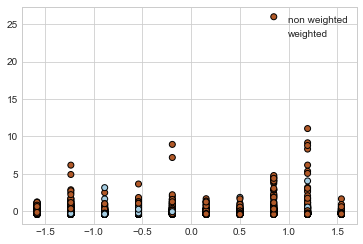

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

# we create two clusters of random points
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)
# print(X)
# print(y)
X = test_x
y = test_y
# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y)

# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight="balanced")
wclf.fit(X, y)

# plot the samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")

# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# print(XX)
# get the separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)
# plt.plot(Z)
# plot decision boundary and margins
a = ax.contour(XX, YY, Z, colors="k", levels=[0], alpha=0.5, linestyles=["-"])

# get the separating hyperplane for weighted classes
Z = wclf.decision_function(xy).reshape(XX.shape)
# print(Z)
# plot decision boundary and margins for weighted classes
b = ax.contour(XX, YY, Z, colors="r", levels=[0], alpha=0.5, linestyles=["-"])

plt.legend(
    [a.collections[0], b.collections[0]],
    ["non weighted", "weighted"],
    loc="upper right",
)
plt.show()

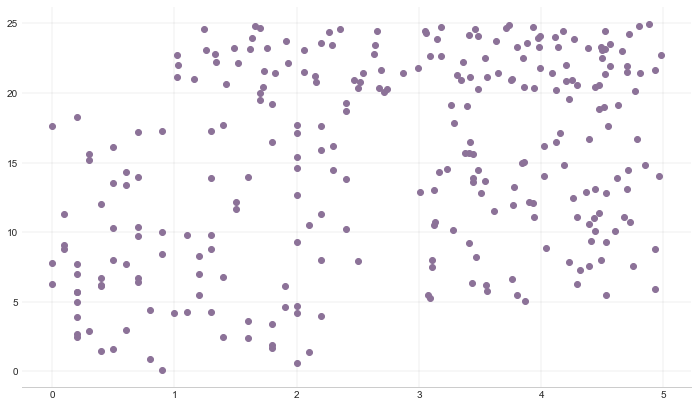

In [287]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def generate_random_dataset(size):
    """ Generate a random dataset and that follows a quadratic  distribution
    """
    x = []
    y = []
    target = []
    for i in range(size):
        # class zero
        x.append(np.round(random.uniform(0, 2.5), 1))
        y.append(np.round(random.uniform(0, 20), 1))
        target.append(0)
        # class one
        x.append(np.round(random.uniform(1, 5), 2))
        y.append(np.round(random.uniform(20, 25), 2))
        target.append(1)
        x.append(np.round(random.uniform(3, 5), 2))
        y.append(np.round(random.uniform(5, 25), 2))
        target.append(1)
    df_x = pd.DataFrame(data=x)
    df_y = pd.DataFrame(data=y)
    df_target = pd.DataFrame(data=target)
    data_frame = pd.concat([df_x, df_y], ignore_index=True, axis=1)
    data_frame = pd.concat([data_frame, df_target], ignore_index=True, axis=1)
    data_frame.columns = ['x', 'y', 'target']
    return data_frame

# Generate dataset
size = 100
dataset = generate_random_dataset(size)
features = dataset[['x', 'y']]
label = dataset['target']
# Hold out 20% of the dataset for training
test_size = int(np.round(size * 0.2, 0))
# Split dataset into training and testing sets
x_train = features[:-test_size].values
y_train = label[:-test_size].values
x_test = features[-test_size:].values
y_test = label[-test_size:].values
# Plotting the training set
fig, ax = plt.subplots(figsize=(12, 7))
# removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# adding major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.scatter(features[:-test_size]['x'], features[:-test_size]['y'], color="#8C7298")
plt.show()

In [ ]:
from sklearn import svm
model = svm.SVC(kernel='poly', degree=2)
model.fit(train_x, train_y)

KeyboardInterrupt: 

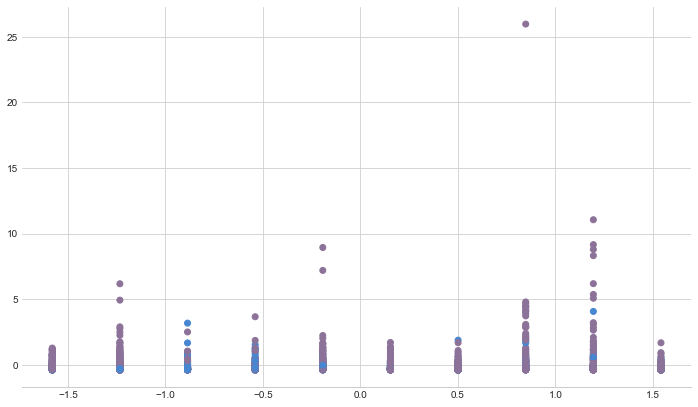

In [299]:
fig, ax = plt.subplots(figsize=(12, 7))
# Removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# Create grid to evaluate model
xx = np.linspace(-1, max(features['x']) + 1, len(train_x))
yy = np.linspace(0, max(features['y']) + 1, len(train_y))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
train_size = len(features[:-test_size]['x'])
# Assigning different colors to the classes
colors = test_y
colors = np.where(colors == 1, '#8C7298', '#4786D1')
# Plot the dataset
# print(test_x)
ax.scatter(test_x[:, 0], test_x[:, 1], c=colors)
# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)
# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [303]:
# inputs = tf.keras.Input(shape=(2))
# # targets = keras.Input(shape=(10,))
# x = tf.keras.layers.Dense(64, activation="relu")(inputs)

# x = tf.keras.layers.Dense(1, activation="sigmoid")(x)


# classifier = tf.keras.Model(inputs=(inputs), outputs=[x], name="binaryClassifier")
# classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
#         tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')
# ])
# # student_model.save("models/alexNetv6_second_Exit.hdf5")
# classifier.summary()


classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classifier.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [308]:
classifier.fit(train_x,train_y, epochs=9,class_weight={0:10,1:1})

Epoch 1/9
250/250 [==============================] - 1s 4ms/step - loss: 1.6209 - accuracy: 0.2096 - precision: 0.8218 - recall: 0.0348
Epoch 2/9
250/250 [==============================] - 1s 4ms/step - loss: 1.6037 - accuracy: 0.2165 - precision: 0.8816 - recall: 0.0412
Epoch 3/9
250/250 [==============================] - 1s 4ms/step - loss: 1.6035 - accuracy: 0.2111 - precision: 0.8857 - recall: 0.0334
Epoch 4/9
250/250 [==============================] - 1s 4ms/step - loss: 1.6061 - accuracy: 0.2128 - precision: 0.8885 - recall: 0.0355
Epoch 5/9
250/250 [==============================] - 1s 4ms/step - loss: 1.6078 - accuracy: 0.1988 - precision: 0.8516 - recall: 0.0168
Epoch 6/9
250/250 [==============================] - 1s 4ms/step - loss: 1.6036 - accuracy: 0.1992 - precision: 0.8983 - recall: 0.0163
Epoch 7/9
250/250 [==============================] - 1s 4ms/step - loss: 1.6054 - accuracy: 0.2039 - precision: 0.8659 - recall: 0.0238
Epoch 8/9
250/250 [=============================

In [239]:
classifier.evaluate(test_x,test_y)

63/63 [==============================] - 0s 3ms/step - loss: 0.4667 - accuracy: 0.8085 - precision: 0.8085 - recall: 1.0000


[0.46671178936958313, 0.8084999918937683, 0.8084999918937683, 1.0]

In [240]:
# print(features[:5])
results =[]
for i, x in enumerate(test_x):
    # if i > 10:
        # break
    x = x.reshape(1,2)
    # print(x)
    # print(np.array(x).shape)
    result = classifier.predict(x)
    # print(result)
    results.append(np.squeeze(result.tolist()))

results = [
    1 if prob > 0.5 else 0 for prob in np.ravel(results)
]
accuracy = 0
for i,x in enumerate(results):
    # print(x, test_y[i])
    if x == test_y[i]:
        accuracy = accuracy + 1
print(accuracy/len(results))
# print(results[:10])
# print(true_labels[:10])

0.8085


[[   0  383]
 [   0 1617]]


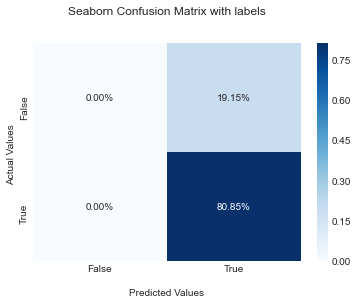

In [242]:
from sklearn.metrics import confusion_matrix
#Generate the confusion matrix
cf_matrix = confusion_matrix(test_y, results)
print(cf_matrix)
import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

1001
1001
1001


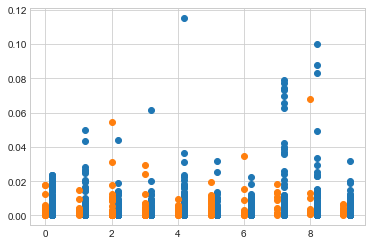

In [125]:
print(features[:,1].size)
print(features[:,0].size)
print(true_labels.size)
plt.scatter(Trues[:,0], Trues[:,1])
plt.scatter(Falses[:,0], Falses[:,1])

In [116]:
reg = LinearRegression().fit(features,true_labels)
reg.score(features,true_labels)

# reg.coef_

# reg.intercept_

reg.predict(features)


array([0.78823228, 0.87105382, 0.88275279, ..., 0.78529673, 0.92740711,
       0.82061929])

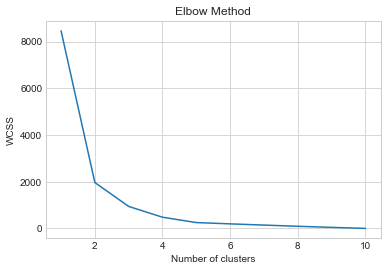

In [60]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

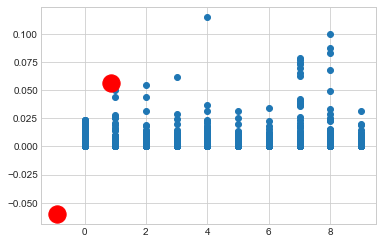

In [93]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(scaled_features)
plt.scatter(features[:,0], features[:,1],)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [94]:
print(kmeans.labels_[:15])
print(true_labels[:15])

[0 1 1 0 1 1 0 1 0 0 0 1 1 1 1]
[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [92]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print(scaled_features[:5])

[[-0.5514842  -0.26481927]
 [ 1.16825314 -0.22331414]
 [ 1.16825314  0.64455279]
 [-1.5833266  -0.09866509]
 [ 0.4803582   0.60230442]]


In [21]:
# Calculate seeds from kmeans++
centers_init, indices = kmeans_plusplus(scaled_features, n_clusters=2, random_state=0)
# Plot init seeds along side sample data

kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=42
)


In [13]:
kmeans.fit(features)

KMeans(init='random', n_clusters=2, random_state=42)

In [14]:
# The lowest SSE value
print(kmeans.inertia_)


# Final locations of the centroid
print(kmeans.cluster_centers_)





# The number of iterations required to converge
kmeans.n_iter_

1963.0247119877295
[[7.07364341e+00 6.21600425e-03]
 [1.97525773e+00 5.49764369e-03]]


3

In [15]:
kmeans.labels_[:5]

array([1, 0, 0, 1, 0])

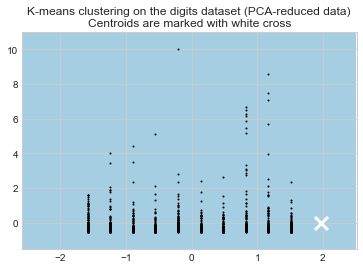

In [16]:
reduced_data = scaled_features
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()